In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from keras.models import Model
from keras import backend as K


%matplotlib inline
import matplotlib.pyplot as plt

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

# network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed


from sklearn.neighbors import kneighbors_graph
import pandas as pd
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from keras.models import load_model
from sklearn.cluster import KMeans
import seaborn as sns

import tensorflow as tf
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from scipy import sparse
from scipy import linalg
from sklearn.manifold import TSNE
import time

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

RANDOM_SEED = 123
seed(RANDOM_SEED)

Using TensorFlow backend.


Load data

In [2]:
boston = load_boston()

X_train,X_test,y_train,y_test = train_test_split(boston.data,boston.target,test_size=0.1,random_state=0)
X_train = scale(X_train)
X_test = scale(X_test)
y_train = scale(y_train.reshape((-1,1)))
y_test = scale(y_test.reshape((-1,1)))

Construct model

In [ ]:
# model = Sequential()
# model.add(Dense(12, input_dim=8, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

def add_layer(inputs,input_size,output_size,activation_function=None):
    with tf.variable_scope("Weights"):
        Weights = tf.Variable(tf.random_normal(shape=[input_size,output_size]),name="weights")
    with tf.variable_scope("biases"):
        biases = tf.Variable(tf.zeros(shape=[1,output_size]) + 0.1,name="biases")
    with tf.name_scope("Wx_plus_b"):
        Wx_plus_b = tf.matmul(inputs,Weights) + biases
    with tf.name_scope("dropout"):
        Wx_plus_b = tf.nn.dropout(Wx_plus_b,keep_prob=keep_prob_s)
    if activation_function is None:
        return Wx_plus_b
    else:
        with tf.name_scope("activation_function"):
            return activation_function(Wx_plus_b)

xs = tf.placeholder(shape=[None,X_train.shape[1]],dtype=tf.float32,name="inputs")
ys = tf.placeholder(shape=[None,1],dtype=tf.float32,name="y_true")
keep_prob_s = tf.placeholder(dtype=tf.float32)

with tf.name_scope("layer_1"):
    l1 = add_layer(xs,13,10,activation_function=tf.nn.relu)
# with tf.name_scope("layer_2"):
#     l2 = add_layer(l1,6,10,activation_function=tf.nn.relu)
with tf.name_scope("y_pred"):
    pred = add_layer(l1,10,1)

# The more operations here are to save pred operations and restore them. I only know this stupid method.
pred = tf.add(pred,0,name='pred')

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - pred),reduction_indices=[1]))  # mse
    tf.summary.scalar("loss",tensor=loss)
with tf.name_scope("train"):
    # train_op =tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

Data visualization, definition of training parameters

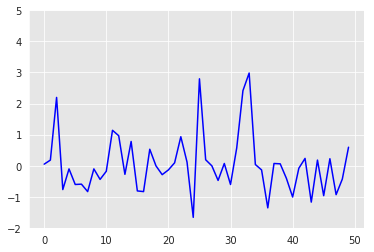

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(50),y_train[0:50],'b')  #Show the first 50 data
ax.set_ylim([-2,5])
plt.ion()
plt.show()

# parameters
keep_prob=1  # To prevent overfitting, the value is generally 0.5 to 0.8. Here is 1, I haven’t done fitting
ITER =5000  # Training times

Training process

In [5]:
def fit(X, y, ax, n, keep_prob):
    init = tf.global_variables_initializer()
    feed_dict_train = {ys: y, xs: X, keep_prob_s: keep_prob}
    with tf.Session() as sess:
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter(logdir="nn_boston_log", graph=sess.graph)  #Write tensorbord
        sess.run(init)
        for i in range(n):
            _loss, _ = sess.run([loss, train_op], feed_dict=feed_dict_train)

            if i % 100 == 0:
                print("epoch:%d\tloss:%.5f" % (i, _loss))
                y_pred = sess.run(pred, feed_dict=feed_dict_train)
                rs = sess.run(merged, feed_dict=feed_dict_train)
                writer.add_summary(summary=rs, global_step=i)  #Write tensorbord
                saver.save(sess=sess, save_path="nn_boston_model/nn_boston.model", global_step=i) # Save model
                try:
                    ax.lines.remove(lines[0])
                except:
                    pass
                lines = ax.plot(range(50), y_pred[0:50], 'r--')
                plt.pause(1)

        saver.save(sess=sess, save_path="nn_boston_model/nn_boston.model", global_step=n)  # Save model

In [6]:
fit(X=X_train,y=y_train,n=ITER,keep_prob=keep_prob,ax=ax)

epoch:0	loss:235.36322
epoch:100	loss:3.57136
epoch:200	loss:1.53461
epoch:300	loss:0.87813
epoch:400	loss:0.62818
epoch:500	loss:0.50132
epoch:600	loss:0.40892
epoch:700	loss:0.34450
epoch:800	loss:0.30205
epoch:900	loss:0.27511
epoch:1000	loss:0.25445
epoch:1100	loss:0.23910
epoch:1200	loss:0.22620
epoch:1300	loss:0.21467
epoch:1400	loss:0.20469
epoch:1500	loss:0.19548
epoch:1600	loss:0.18719
epoch:1700	loss:0.17859
epoch:1800	loss:0.17135
epoch:1900	loss:0.16460
epoch:2000	loss:0.15851
epoch:2100	loss:0.15177
epoch:2200	loss:0.14586
epoch:2300	loss:0.12003
epoch:2400	loss:0.10961
epoch:2500	loss:0.10290
epoch:2600	loss:0.09707
epoch:2700	loss:0.09284
epoch:2800	loss:0.09053
epoch:2900	loss:0.08876
epoch:3000	loss:0.08743
epoch:3100	loss:0.08620
epoch:3200	loss:0.08522
epoch:3300	loss:0.08409
epoch:3400	loss:0.08259
epoch:3500	loss:0.08148
epoch:3600	loss:0.08051
epoch:3700	loss:0.07964
epoch:3800	loss:0.07890
epoch:3900	loss:0.07804
epoch:4000	loss:0.07746
epoch:4100	loss:0.07694
ep